## PyTorch: A simple two layer fully connected network

Here we will go step by step through implmenting a very simple 2 layer fully connected network to label MNIST digits.

We start with a number of extra imports: pyplot lets us create plots, torch.nn is a torch library for implementing neural nets, and transforms is a torchvision package to help us work with image data, and datasets is a torchvision package granting us access to some built in test data. We will look at importing data in a later example.

In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from timeit import default_timer as timer

In [14]:
# normalize the pixel values to [-1,1] with mean 0.
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (1.0,))])

training_data = dsets.MNIST(root="./data", train = True, transform=transform, download = True)

We should have a **validation set** of data as well, but the built in MNIST caller does not support a validation set, and we will just use the testing data set as the validation set for purpose of this tutorial.

In [15]:
testing_data = dsets.MNIST(root="./data", train = False, transform=transform, download = True)

torch.Size([1, 28, 28])


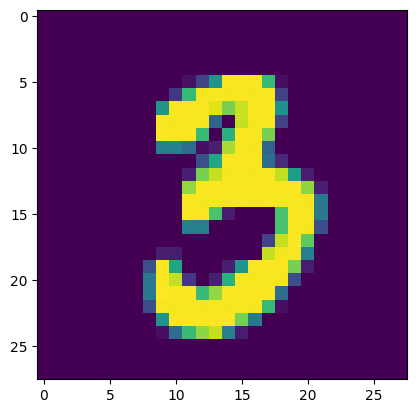

In [16]:
## The mnist data comes in as a tuple. The first index is the pixel values packed in a pytorch Tensor, 
## the 2nd index is the class label.
# To show the image I have to make pytorch tensor a 
training_image_tensor = training_data[890][0]

# Note that the image is a 1x28x28 tensor: there is only one color channel; it is grayscale. 
print(training_image_tensor.shape)
plt.imshow(training_image_tensor[0])

In [17]:
class_label = training_data[890][1]
print(class_label)

3


PyTorch comes with **built-in DataLoaders** that make it trivial to create minibatches and to enumerate over them. Always use these helpers!!

A DataLoader takes as input the desired minibatch size you would like (batch_size), and whether or not you would like the data to be shuffled before it is partitioned into minibatches. No shuffling means the exact same minibatches will be presented to your network every epoch. There is not a lot of guidance as to whether shuffling is good or bad, but intuition says shuffling should help with generalizability a bit.

The DataLoader function returns an *iterator* over your datasets with shuffling and batchsize specified.

In [18]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset=training_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=testing_data, batch_size=len(testing_data), shuffle=False)

len(train_loader)

938

## Setting up a deep net
### 1. Specify and instantiate the network.

Here we go. A DNN is specified as a class that inherets from nn.Module. They all have the same structure:
<ol>
    <li> a call to the constructor of nn.Module (super)
    <li> specification of a number of network layers. It is common practice to wrap the way the nodes are wired and the activation function (and any other processing, like doing batch norm) inside of an nn.Sequential object. nn.Sequential is just a convinent wrapper of a number of nn.function calls. 
    <li> Definition of a **forward** function. This function must be specified. This function describes the way that data will pass through your deep net. Here, we see that the input will bass through fc1, then fc2, and we return thr output of fc2. 
        </ol>
        
A few things to note: 
<ol> 
    <li> We do not need to tell the deep net what the size of the minibatch we will present to it is.
    <li> nn.Linear specifies a linear combination of inputs into a layer. The linear combination is the $\sum_i w_i x_i$ we are used to seeing, where the summation is over **every node in the previous layer**. So nn.Linear specifies a fully-connected connectivity in this layer. 
<li> We simply output the ReLU activation values of fc2 -- we do not normalize these values so they sum to 1. We may want to do a normalization here if we want the network to output a score for the likelihood the input is of each class that looks like a probability. We could do so by specifiying a **softmax** layer. But this is equivalent to just predicting the class corresponding to the fc2 output that is maximum.
    </ol>
    

**The PyTorch docs are a great place to see what types of layers and activations are implemented**. Of course, nothing is stoping you from implementing your own layer or activation function and then call those functions inside of the deep net specification.

In [19]:
class DeepNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(DeepNet, self).__init__()
        
        self.fc1 = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(hidden_size,hidden_size),
            nn.ReLU()
        )
        self.output = nn.Sequential(
            nn.Linear(hidden_size, num_classes),
            nn.ReLU()
        )
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
        out = self.output(out)
        return out

In [20]:
input_size = 28*28 ## Note that an MNIST image is 28*28 pixels.
num_classes = 10
hidden_size = 10
the_net = DeepNet(input_size, hidden_size, num_classes)
print(the_net)

## the parameters() function of an nn.Module object returns an iterator over 
## all of the network parameters (e.g. weights.) PyTorch initializes all weights in linear and
## conv layers as: 
## stdv = 1. / math.sqrt(number_of_layer_inputs)
## self.weight.data.uniform_(-stdv, stdv)
## So with uniformly distributed weights within -stdv, stdv.

## If you want to see what the parameters are, iterate over parameters() or make it a list:
params = list(the_net.parameters())
## We print the parameters of the network in order of weights, then biases, for each layer that has weights and 
## biases, in sequential order of operation in the forward pass. 
print(params)

## If you want to specify your own weight initiaization routine, you can do it simply!
## It is possible to . through the structure of the_net. any Sequential layers are lists, so fc2[0] is the 
## nn.Linear in fc2. fc2[1] is the ReLU activation.
## Remember that _ suffix means in place updating.
the_net.fc2[0].weight.data.normal_(10,0.01)
the_net.fc2[0].bias.data.normal_(50,0.01)
print(params)

## anyway, these weights are horrible. Let's reinitialize the network. :) 
the_net = DeepNet(input_size, hidden_size, num_classes)
print(list(the_net.parameters()))

##BTW, how many parameters do we have? 
num_parameters = 0
for x in the_net.parameters():
    print(x.shape)
for x in the_net.parameters():
    num_params = 1
    for dim_size in x.shape:
        num_params *= dim_size
    num_parameters += num_params
print('number of network parameters: %i' % (num_parameters))


DeepNet(
  (fc1): Sequential(
    (0): Linear(in_features=784, out_features=10, bias=True)
    (1): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
  )
  (output): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
  )
)
[Parameter containing:
tensor([[-0.0236,  0.0214, -0.0319,  ..., -0.0040,  0.0114, -0.0301],
        [-0.0278, -0.0142, -0.0270,  ..., -0.0117, -0.0211, -0.0269],
        [ 0.0335,  0.0127,  0.0172,  ...,  0.0111, -0.0168, -0.0119],
        ...,
        [-0.0132, -0.0237, -0.0084,  ..., -0.0007,  0.0120,  0.0231],
        [-0.0191,  0.0302,  0.0221,  ...,  0.0011, -0.0002, -0.0291],
        [ 0.0331,  0.0301, -0.0283,  ...,  0.0329, -0.0138,  0.0002]],
       requires_grad=True), Parameter containing:
tensor([-0.0008, -0.0053,  0.0069,  0.0133, -0.0057, -0.0177,  0.0060,  0.0292,
        -0.0132,  0.0092], requires_grad=True), Parameter containing:
tensor([[-0.0938, -0.2699

### 2. Define your loss function.

Since we are tackling a classification problem we want to use cross entropy loss. For those who know cross entropy (or have heard of **entropy** before) would know that the loss must operate on a probability distribution. And indeed it does: this loss expects the probability the network thinks the input is of each class. In PyTorch, **this normalization (e.g. passing the output of fc2 through a *softmax layer*) is done automatically by the loss function**. I (Derek) don't really like this, its a bit of a gotcha! Now you know!

In [21]:
loss_function = nn.CrossEntropyLoss()

### 3. Define your optimizer.

When in doubt, start with SGD with a small learning rate parameter.

In [22]:
optimizer = torch.optim.SGD(the_net.parameters(), lr=0.01)

### 4. Begin training.
We will train in a loop that iterates over the minibatches yielded from train_loader, for a fixed number of epochs. Here is what's going on: 
<ol>
    <li> We are specifying a loop for 10 epochs. In the loop we wrap the train_loader in an enumerator. The enumerator will yield an enumeration count and a tuple (minibatch_of_images, minibatch_of_labels). 
    <li> The minibatch_of_images is a 4D tensor with dimensions (size_of_minibatch, depth, width, height). The network expects as input a vector of size 28*28 so we need to reshape the tensor accordingly. We will reshape it to a matrix of 32 rows, 28*28 columns. Note that we can pass -1 as the first parameter of view, this is like saying "I don't know how many rows I'll need, just make as many as needed to the column count I specify (28*28) is satisfied.

In [24]:
num_epochs = 3
for epoch in range(num_epochs):
    for _ , (minibatch_of_images, minibatch_of_labels) in enumerate(train_loader):
        print(minibatch_of_images.shape)
        print(minibatch_of_images.view(32, 28*28).shape)
        break

torch.Size([64, 1, 28, 28])


RuntimeError: shape '[32, 784]' is invalid for input of size 50176

<ol>
    <li> We build a computation graph here to setup backprop! So wrap the labels and the batch in a Variable.
    <li> Tell the optimizer to zero out any gradient stored in the Variables of the parameters of the_net. Indeed, the optimizer knows of the_net's parameters as we passed them in as a required parameter of the optimizer above. **Zero the gradient out after every minibatch!**
     <li> Okay, run the_batch through the_net. This is the **forward pass**. Note that outputs will be a Variable.
     <li> Compute the loss, how much error the network had on the_batch.
     <li> Now backprop! loss is a real number value, so that will be the gradient signal. Observe. loss is a functino of the outputs, which is a function of the_net, which is a function of the_batch. So the computation chain is all setup! 
      <li> Tell the optimizer to update the weights by calling step(). Step tells the optimizer to use the gradients stored at each network parameter (computed by calling backward() on loss) to compute and apply a weight update.
      <li> Give some console output to see how we are doing every few minibatches.

In [10]:
num_epochs = 25
for epoch in range(num_epochs):
    start = timer()
    for batch_num , (minibatch_of_images, minibatch_of_labels) in enumerate(train_loader):
    
        the_batch = Variable(minibatch_of_images.view(-1, 28*28))
        labels = Variable(minibatch_of_labels)
        
        optimizer.zero_grad()
        
        output = the_net(the_batch)
        
        loss = loss_function(output, labels)
        
        loss.backward()
        
        optimizer.step()
        
        _, predicted = torch.max(output.data, 1)

        # we want to check the accuracy with test dataset every 300 iterations.
        if batch_num % 300 == 0:
            print("At epoch %i, minibatch %i. Loss: %.4f." % (epoch, batch_num, loss.data[0]))
            
    end = timer()
    print("Epoch %i finished! It took: %.4f seconds" % (epoch, end - start))
    correct = 0
    total = 0
    for data in test_loader:
        images, labels = data
        outputs = the_net(Variable(images.view(-1,28*28)))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
    correct += (predicted == labels).sum()
    print('Accuracy of the network on the %d test images: %.2f %%' % (total, 100.0 * correct / total))

At epoch 0, minibatch 0. Loss: 2.2961.
At epoch 0, minibatch 300. Loss: 1.7185.
At epoch 0, minibatch 600. Loss: 1.2413.
At epoch 0, minibatch 900. Loss: 0.5460.
Epoch 0 finished! It took: 4.6194 seconds
Accuracy of the network on the 10000 test images: 75.04 %
At epoch 1, minibatch 0. Loss: 0.7775.
At epoch 1, minibatch 300. Loss: 0.7185.
At epoch 1, minibatch 600. Loss: 0.5047.
At epoch 1, minibatch 900. Loss: 0.4089.
Epoch 1 finished! It took: 4.5623 seconds
Accuracy of the network on the 10000 test images: 84.66 %
At epoch 2, minibatch 0. Loss: 0.4307.
At epoch 2, minibatch 300. Loss: 0.3394.
At epoch 2, minibatch 600. Loss: 0.6411.
At epoch 2, minibatch 900. Loss: 0.4371.
Epoch 2 finished! It took: 4.5404 seconds
Accuracy of the network on the 10000 test images: 87.21 %
At epoch 3, minibatch 0. Loss: 0.2563.
At epoch 3, minibatch 300. Loss: 0.3732.
At epoch 3, minibatch 600. Loss: 0.3172.
At epoch 3, minibatch 900. Loss: 0.5036.
Epoch 3 finished! It took: 4.4547 seconds
Accuracy o

In [2]:
torch.cuda.is_available()

True

Author: Derek Doran, Dept. of CSE, Wright State University, for ATRC Summer 2018. 

Homepage: https://derk--.github.io/